# neu 350 spring 2021<br>week 4: analyzing the H1 visual interneuron

## contents

* [0. preamble](#head)
* [1. loading libraries](#lib)  
* [2. getting started](#load)
* [3. separating data into trials](#chunk)
* [4. separating into windows or bins](#sep)
* [5. making a tuning curve](#tune)

---

Please report any bugs/problems with this notebook to [Ed Discussion](https://edstem.org/us/courses/4492/discussion/).  

<u>Version 2021-02-21.</u> Tested to be compatible with:
* python 3.8.5
* numpy 1.19.2
* matplotlib 3.3.2
* jupyter notebook 6.1.4
* pyabf 2.2.8


<a id="head"></a>
## 0. Preamble

This week's experiment features recordings from the blowfly H1 interneuron, which measures optic flow in the fly's visual field.

If you have not already, you should familiarize yourself with the experiment using the materials posted to Canvas.

This notebook is not a flowchart of progressive steps in analysis, and does not represent the scope of analysis we expect you to perform for your figure.  We would instead encourage you consider the techniques described here as components of a toolbox of techniques from which you make a purposeful choice about what you choose to implement.

### Relevant techniques already in our toolbox

* <span style="color:magenta">__peak detection__</span>
* <span style="color:magenta">__data wrangling__</span>
* <span style="color:magenta">__frequency analysis__</span>

Last week a significant chunk of the work that went into generating your figure was actually the data wrangling upstream of the actual analysis -- how to cut your data into the appropriate chunks.  Here again there is a similar data wrangling task ahead of generating the tuning curve: namely, how to separate a continuous recording into epochs of a repeated stimulus.

### Techniques we introduce in this notebook
* more <span style="color:magenta">__data wrangling__</span>, separating trials and windows for freq analysis
* <span style="color:magenta">__tuning curves__</span>

<a id="lib"></a>
## 1. Loading Libraries

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as pl
import pyabf
import csv

!python --version
print("Loaded: numpy ver", np.__version__, ", matplotlib ver", matplotlib.__version__,
      ", pyabf ver", pyabf.__version__)

Python 3.8.5
Loaded: numpy ver 1.19.2 , matplotlib ver 3.3.2 , pyabf ver 2.3.3


In [3]:
import matplotlib
%matplotlib notebook

<a id="load"></a>
## 2. getting started

In [6]:
# we will load two sample data files. the first will show confirmation that we have H1
# by capturing response to a stimulus that alternates between excitatory and inhibitory; 
# the second will show continuous stimulation across a constantly varying stimulus parameter
# (in this case, the width of the bars)

datafiles=["005.abf","014.abf"]

h1 = []; pos = []; times = []  # initialize lists.  we use lists rather than arrays 
                               # because we don't assume the same recording length

for file in datafiles:    

    data = pyabf.ABF(file)

    data.setSweep(sweepNumber=0, channel=0) # fly lobula plate field recording.  dominant unit is H1.
    h1.append(data.sweepY)
    h1_label = data.sweepLabelY

    data.setSweep(sweepNumber=0, channel=1) # spinner position signal **
    pos.append(data.sweepY)
    pos_label = data.sweepLabelY

    times.append(data.sweepX) # time in seconds

# ** this time, position signal is reported as a raw voltage.  
# 360 degrees of rotation are mapped to 0:5 volts position signal.
# want to convert?
# degrees_from_Vs = np.interp(Vs,[0,5],[0,360])

<IPython.core.display.Javascript object>


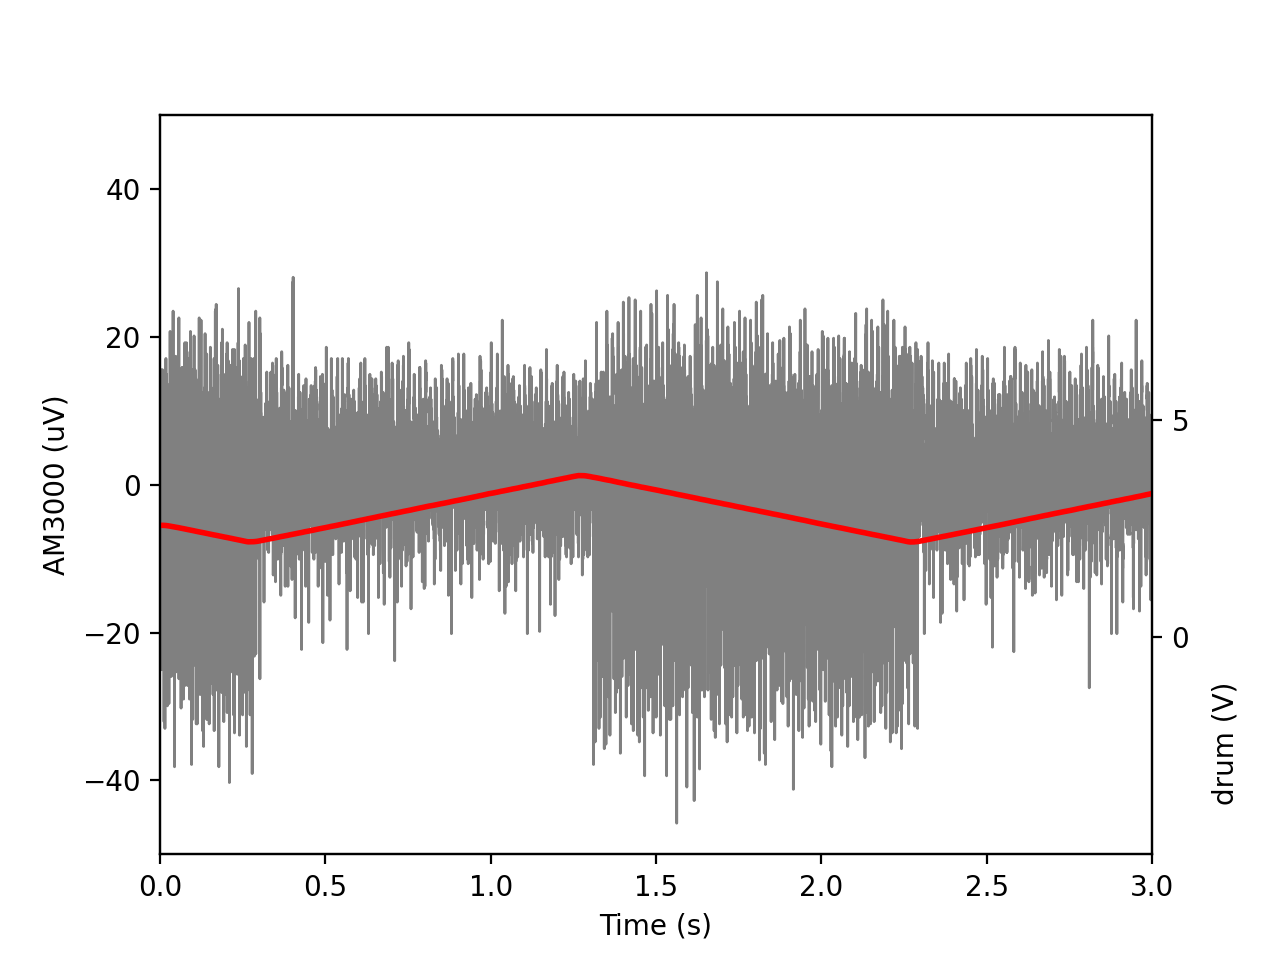

In [9]:
# plot the H1 trace and the position signal as a function of time for the oscillating stimulus.

fig1,ax1 = pl.subplots()
ax1.plot(times[0], h1[0], color='gray', lw=1)
ax1.set_ylim(-50,50)
ax1.set_ylabel(h1_label)
ax1.set_xlabel('Time (s)')

ax1a = ax1.twinx()
ax1a.plot(times[0], pos[0], color='red', lw=2)
ax1a.set_ylabel(pos_label)
ax1a.set_ylim(-3, 50)
ax1a.set_yticks([0,5])
ax1a.yaxis.set_label_coords(1.06,0.15)
ax1.set_xlim(0,3)
ax1a.set_ylim(-5,12)
pl.show()

<div class="alert alert-block alert-info"> Zoom in to see just a few oscillations.  This demonstrates that there is an H1 response.  (How?) </div>

<IPython.core.display.Javascript object>


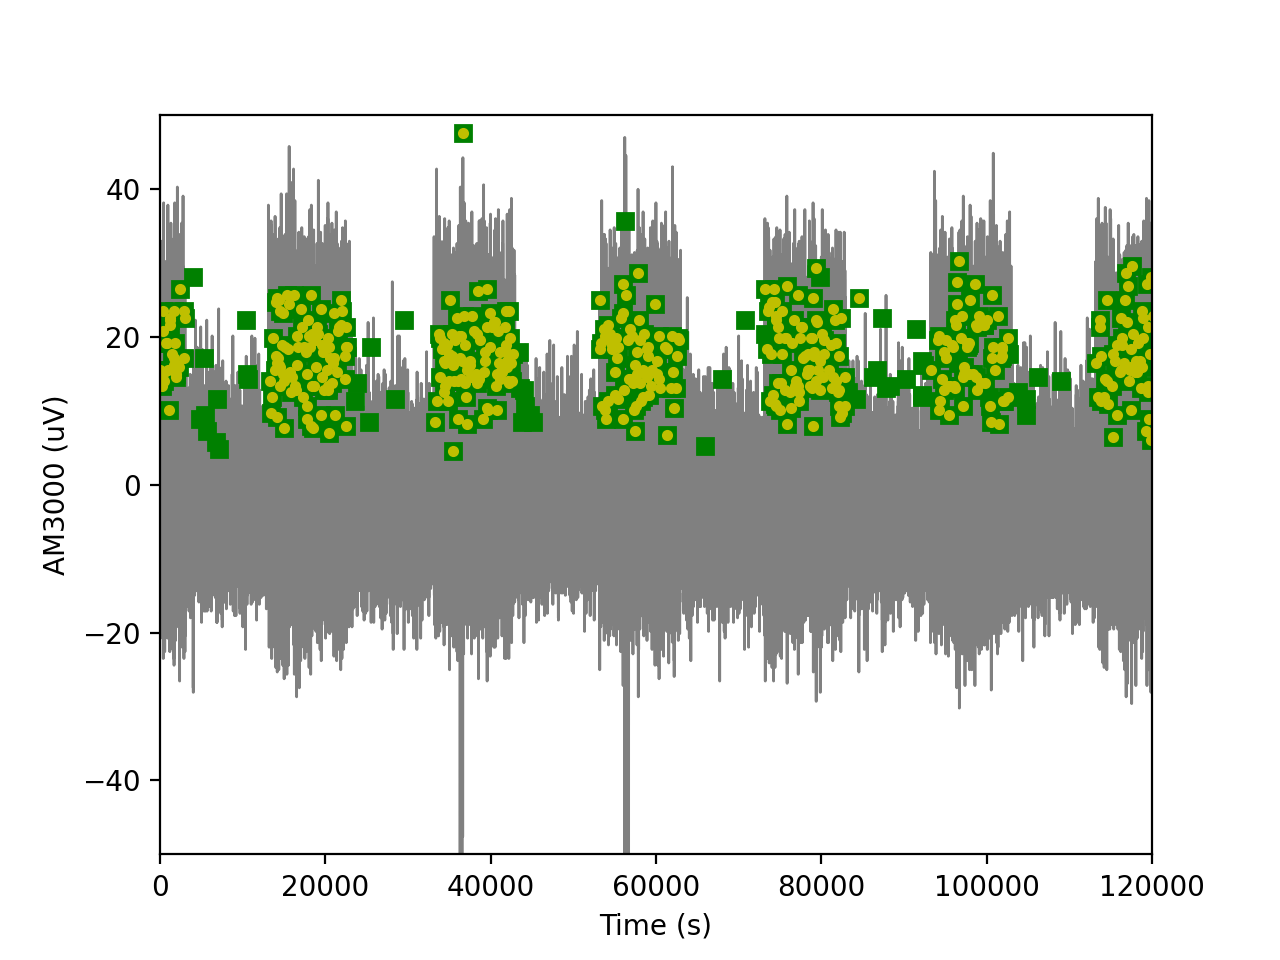

In [15]:
# plot just the H1 trace to optimize peak detection params
# (it's easier if we can look at x in terms of indices) 

fig2,ax2 = pl.subplots()
ax2.plot(h1[0], color='gray', lw=1)
ax2.set_ylim(-50,50)
ax2.set_ylabel(h1_label)
ax2.set_xlabel('Time (s)')

ax2.set_xlim(0,120000)
pl.show()

<div class="alert alert-block alert-info"> Seeing the SNR is better in the downward going direction, let's multiply data by -1 to make peak detection easier.   (Regenerate figure 1 and the subsequent zoom in to see the result.)  <b>Probably sensible to move this up into your data load step so you don't have to keep track of whether you ran this cell for each piece of data you load.</b></div>

In [16]:
for trace in h1:
    trace *= -1

<span style="color:#1d83b5">

<b>We need to use this file to set initial parameters for peak detection, since we don't have regions without H1 firing in the continuous stim files.</b>  
    
There is some rhythmic noise in the signal that makes it hard to call the peaks with a simple amplitude threshold.  There are three choices in how to respond to that: 
* filter out the rhythmic noise
* ignore it
* define peaks with prominence and filter the peaks after detection.
    
I will proceed with with the last approach, which is a middle ground.  Whatever you choose, you should zoom in to your experimental data file to assess how peak finding is working there.  Even though we set initial parameters here, the SNR ratio can drift a bit (generally down) over time.  If you want to be thorough, you can test your peak detection on file __013.abf__ which is a repeat of the oscillating stimulus taken toward the end of the data acquisition sequence.

It is not critically important to get H1 discrimination here perfect.  For the first thing, H1 activity in the inhibitory part of the stim is not necessarily zero; and second, the high frequency activity of H1 response during stimulation will drive the analysis even when contaminated with other units.</span>

In [17]:
# the problem with using prominence is that prominence picks the *lowest* contour line, and our
# best discriminator here is the *highest* contour line.  We'll pick peaks liberally, with a small 
# prominence (15) compared to our expectation (30), and then filter based on the calculated contours.

# I determined my initial prominence and wlen parameters by plotting just the h1[0] data array
# and zooming in to <0.01 s x range, and examining 5 or so peaks by eye, and comparing those
# to a few peaks in the non-excitatory stimulus range.

from scipy.signal import find_peaks

# thresh = 80
dist = 10
prom = 15
wlen = 11

peaks, properties = find_peaks(h1[0], distance=dist, prominence = prom, wlen = wlen)    
peak_heights = h1[0][peaks]  # note we're still on item 0 from the list of voltage traces above.
peak_times = h1[0][peaks]    # change according to however you load the experimental data.


ax2.plot(peaks, peak_heights, 'gs') # green square = initially detected peaks

# prominences for debugging purposes.  doesn't have a function in your final figure.
# ax1.vlines(x=peaks, ymin=peak_heights - properties["prominences"],
#            ymax = peak_heights, color = "orange") 

# now filter peaks

filt_peaks = []

for i in range(len(peaks)):
    x1 = min(h1[0][properties["left_bases"][i]], h1[0][properties["right_bases"][i]]) #take the lower yval
    delta = peak_heights[i] - x1 # distance from minimum contour
    if delta > 30:               # this is the value we tweak to find different peaks
        filt_peaks.append(peaks[i])

ax2.plot(filt_peaks, h1[0][filt_peaks], 'y.') # yellow dot = filtered peaks


<a id="chunk"></a>
## 3. separating trials

<span style="color:#1d83b5">
<br><br>That was a bit more work than we're accustomed to just to set our peak detection parameters!

You can use the above file to generate a panel in your figure showing that we've actually recorded from H1, by demonstrating the directional selectivity of the response.  A raw data trace with detected peaks is adequate to this purpose.

Next we will look at one of the experimental data files with continuous instead of oscillating stimuli.

Note that best practices here would be to load all the files into a list of voltage traces (as I did for the two sample files; see also notebook 02.2) and process them in loops or functions.</span>

<IPython.core.display.Javascript object>


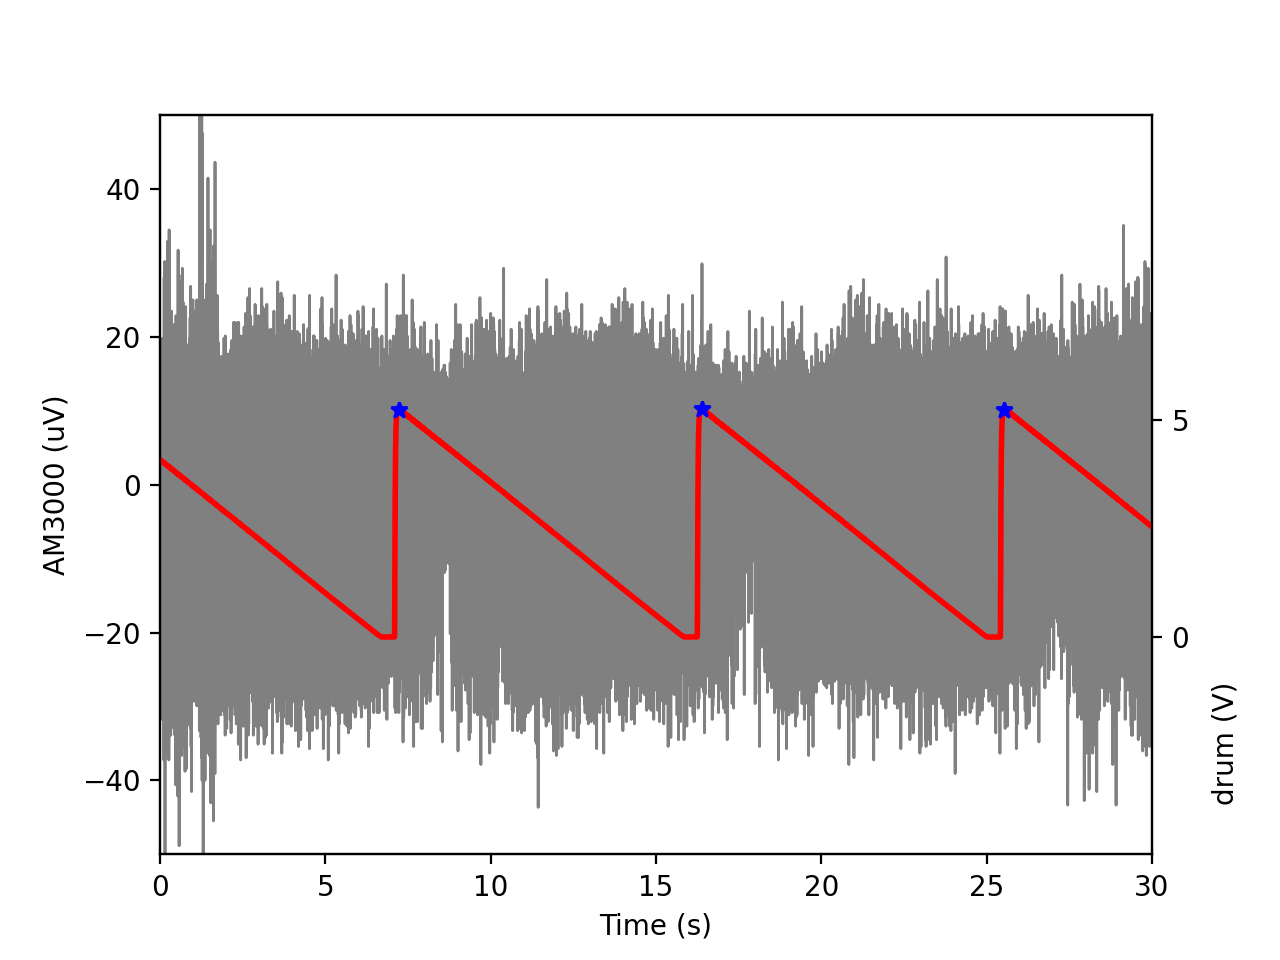

In [18]:
# step 1: plot the continuous stim file

fig3,ax3 = pl.subplots()
ax3.plot(times[1], h1[1], color='gray', lw=1)
ax3.set_ylim(-50,50)
ax3.set_ylabel(h1_label)
ax3.set_xlabel('Time (s)')

ax3a = ax3.twinx()
ax3a.plot(times[1], pos[1], color='red', lw=2)
ax3a.set_ylabel(pos_label)
ax3a.set_ylim(-3, 50)
ax3a.set_yticks([0,5])
ax3a.yaxis.set_label_coords(1.06,0.15)
pl.show()

In [19]:
# a bit hard to follow when we're this zoomed out; let's zoom in

ax3.set_xlim(0,30)
ax3a.set_ylim(-5,12)

(-5.0, 12.0)

<span style="color:#1d83b5">

Can't really make too much sense of the firing rate at this resolution (though there is a dip around 8.5 and 17.6 seconds), but it gives a good sense of the position signal, which we will use to separate the data into individual stimulus epochs/revolutions.  We can already get an eyeball approximation of the time for a single revolution: peak to peak is about 9 seconds.</span>

In [20]:
# step 2: let's determine revolution time with a bit more precision
# how? let's find the peaks in the position signal and see how far apart they are in time.
# much simpler peak-finding!

pos_peaks,_ = find_peaks(pos[1],height=4.5, distance=20000) #dist=2sec

pos_peak_heights = pos[1][pos_peaks]
pos_peak_times = times[1][pos_peaks]

# print(pos_peaks, pos[1][pos_peaks])
ax3a.plot(pos_peak_times,pos_peak_heights,'b*')


In [21]:
# calculate the average time for a revolution

mean_diff = np.mean(np.diff(pos_peaks))
std_diff  = np.std(np.diff(pos_peaks))

mean_diff_s = np.mean(np.diff(pos_peak_times))
std_diff_s  = np.std(np.diff(pos_peak_times))

print(f"average revolution = {mean_diff:.2f} ± {std_diff:.2f} samples or")
print(f"                     {mean_diff_s:.2f} ± {std_diff_s:.2f} seconds")

average revolution = 91596.06 ± 127.46 samples or
                     9.16 ± 0.01 seconds


<div class="alert alert-block alert-danger"> The sample data file <b>014.abf</b> is calibrated such that an individual trial begins (i.e., one edge of the stimulus strip comes into frame) at time=0.  <b>This is not the calibration paradigm for the experimental files.</b>  For trials where the same speed is used, a trial should take about the same time, but the stimulus is calibrated such that the <b>stimulus begins at position signal = 5V</b>, not in reference to the time coordinate.  This means that you will have to separate your data at those peaks detected above rather than beginning at t=0.</div>

In [22]:
# step 3: use the revolution time to pull out successive trials.

length_of_trial = int(mean_diff) # ~91.6k samples for sample data

data_trials = []
pos_trials = []
times_trials = np.asarray(times[0][0:length_of_trial])

# add each trial to data_trials and pos_trials (why not times_trials??)

start_index = 0 # this is what you need to change for a different calibration.

# you can throw away the data in the partial trials at the beginning and end of the recording --
# not necessarily or best practice; you can capture them if you're so inclined.

while start_index + length_of_trial < len(h1[1]):
    data_trials.append(h1[1][start_index:start_index + length_of_trial])
    pos_trials.append(pos[1][start_index:start_index + length_of_trial])
    start_index += length_of_trial

data_trials = np.array(data_trials)
pos_trials = np.array(pos_trials)

print("shapes after concatenation:", data_trials.shape, pos_trials.shape, times_trials.shape)

# look at your data & check to make sure this makes sense


shapes after concatenation: (35, 91596) (35, 91596) (91596,)


<IPython.core.display.Javascript object>


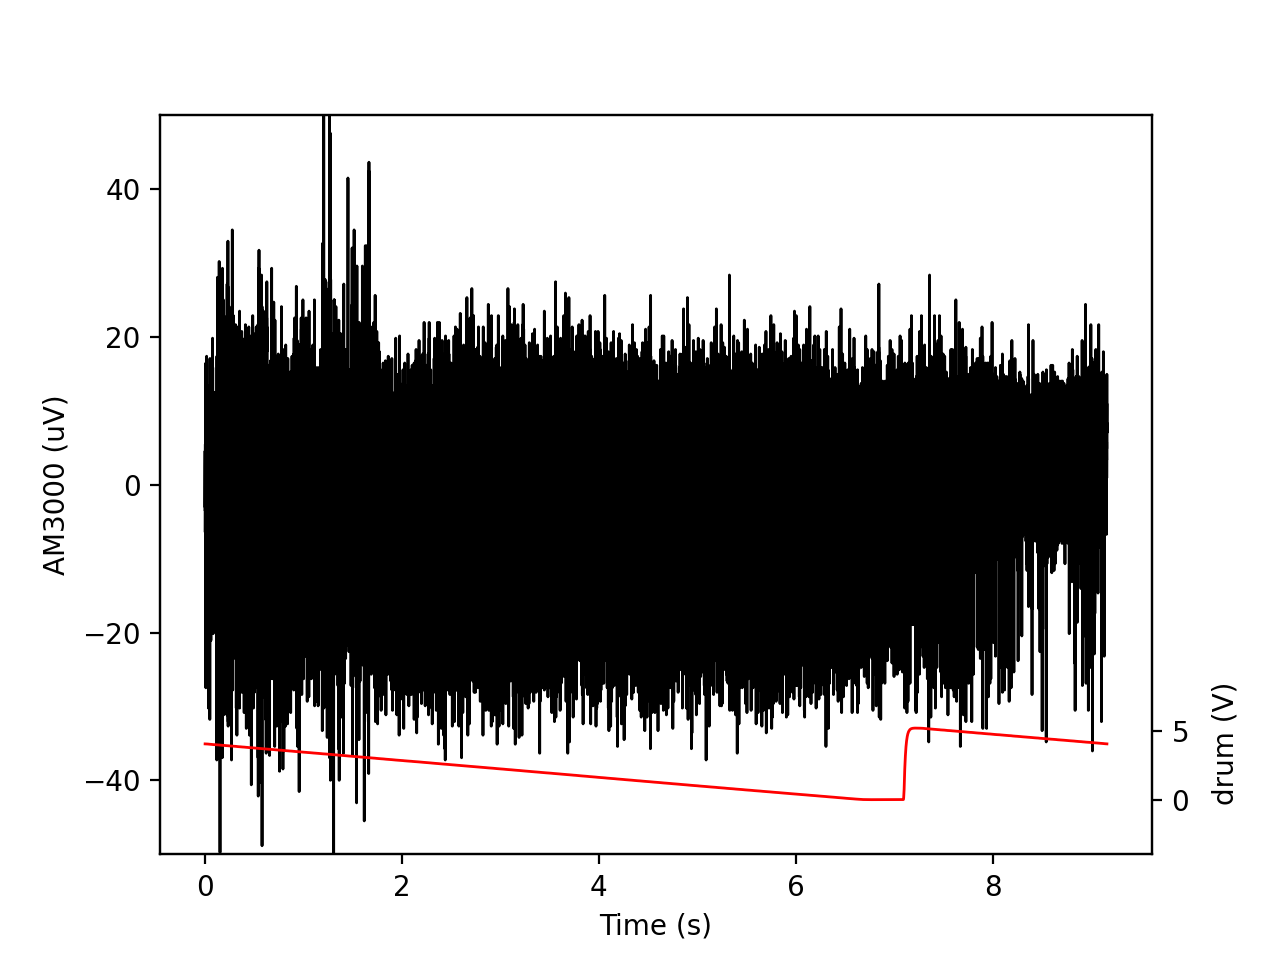

In [23]:
# plot one trial

fig4,ax4 = pl.subplots()
ax4.plot(times_trials, data_trials[0], color='black', lw=1)
ax4.set_ylim(-50,50)
ax4.set_ylabel(h1_label)
ax4.set_xlabel('Time (s)')

ax4a = ax4.twinx()
ax4a.plot(times_trials, pos_trials[0], color='red', lw=1)
ax4a.set_ylabel(pos_label)
ax4a.set_ylim(-4, 50)
ax4a.set_yticks([0,5])
ax4a.yaxis.set_label_coords(1.06,0.15)

<div class="alert alert-block alert-success"> <b>I am skipping some steps here!</b>  You will need to <ol>
<li>detect peaks on your trials, and</li>
    <li>modify the code block below to use those detected peaks to calculate a firing rate in each chunk.</li></ol>
     <b>I am pretending I have done this and treating my voltage trace like it's a windowed frequency trace.</b><br><br>One suggestion: be careful you don't make your windows so small that you don't pick up any spikes when your neuron is active!<br><br>If you are wondering about what step it's okay to average, check out the Ed Discussion post on this topic from last week.</div>
     
<a id="sep"></a>
## 4. separating trials into windows or bins

<IPython.core.display.Javascript object>


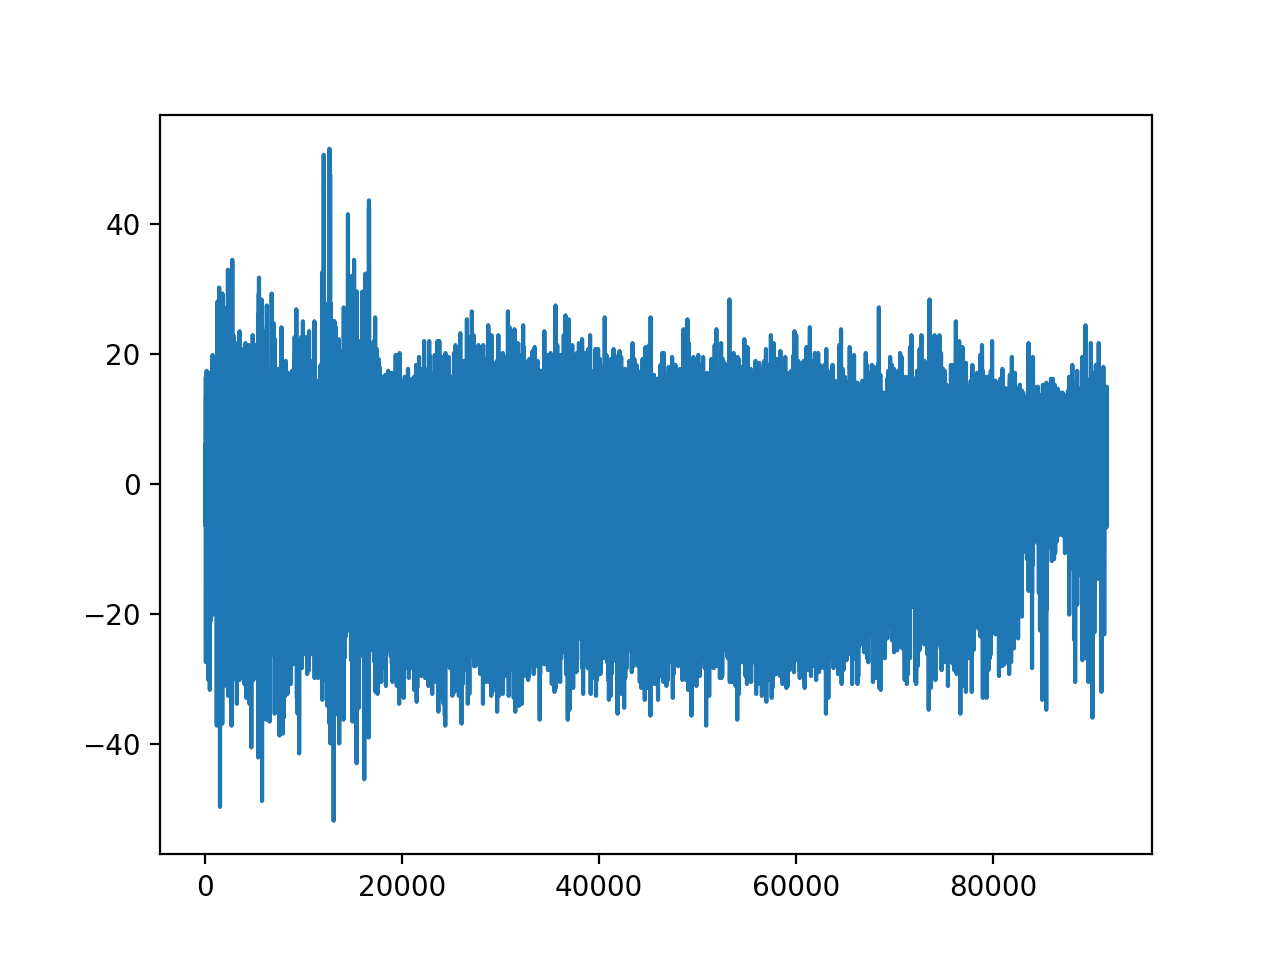

[[2.2234 2.1899 2.3692 ... 2.2045 2.2395 2.216 ]
 [2.2052 2.2234 2.1977 ... 2.2286 2.2721 2.231 ]
 [2.2655 2.2383 2.2513 ... 2.2601 2.1937 2.3141]
 ...
 [2.1903 2.2181 2.1934 ... 2.1092 2.2018 2.1076]
 [2.217  2.1009 2.162  ... 2.1404 2.1696 2.1673]
 [2.1642 2.1204 2.1876 ... 2.2421 2.073  2.1915]]


In [24]:
# separating an individual trial into chunks is the same logic we used to separate 
# the trials above.  looks a bit more complicated because we're stepping through 
# all of our trials as we do this.


num_of_chunks = 20
num_of_trials = np.size(data_trials,0)
start_index = 0
length_of_chunk = int(length_of_trial/num_of_chunks)
times_of_chunks = np.zeros(num_of_chunks) 

avg_voltages_bytrial = np.zeros(shape=(num_of_trials,num_of_chunks))
avg_pos_bytrial = np.zeros(shape=(num_of_trials,num_of_chunks))

pl.subplots()

pl.plot(data_trials[0])

for trial_no in range(num_of_trials):
    i = 0; j = 0  # i = starting index of chunk; j = chunk number

    
    
    for j in range(num_of_chunks):    
        
        # find peaks here
        # find peaks on the same chunk I took average voltage of below
        # count peaks in chunk = len(peaks)
        # (count of peaks / length_of_chunk * 10k) = firing rate
        # put it in the data structure that gets printed below.  
        # the output should make sense compared to what you would guess by eye.
        
        avg_voltages_bytrial[trial_no,j] = np.average(data_trials[trial_no][i:i+length_of_chunk])
        #   avg voltage @ [trial, chunk] =  average voltage of trial    @indices defined by chunk]
        
        avg_pos_bytrial[trial_no,j] = np.average(pos_trials[trial_no][i:i+length_of_chunk])
        
        if trial_no == 0:
            times_of_chunks[j] = np.average(times[0][i:i+length_of_chunk])
            
        i += length_of_chunk; j +=1
            
print(avg_voltages_bytrial)

<IPython.core.display.Javascript object>


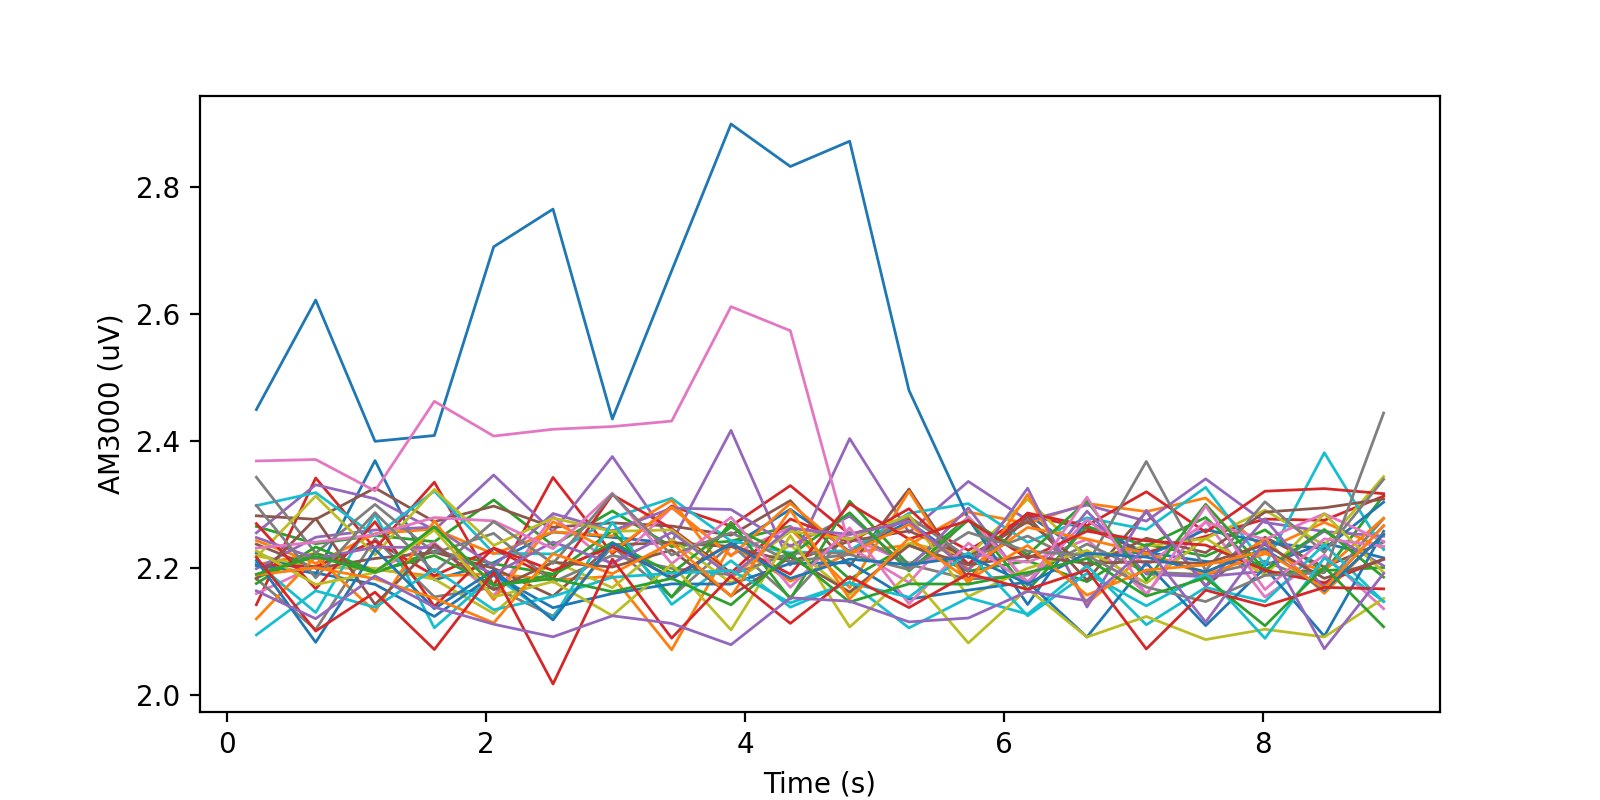

35

In [28]:
# plot each of the chunk-averaged voltage traces

fig5,ax5 = pl.subplots(figsize = (8,4))

for trial in avg_voltages_bytrial:
    ax5.plot(times_of_chunks, trial, lw=1)

ax5.set_ylabel(h1_label)
ax5.set_xlabel('Time (s)')


<IPython.core.display.Javascript object>


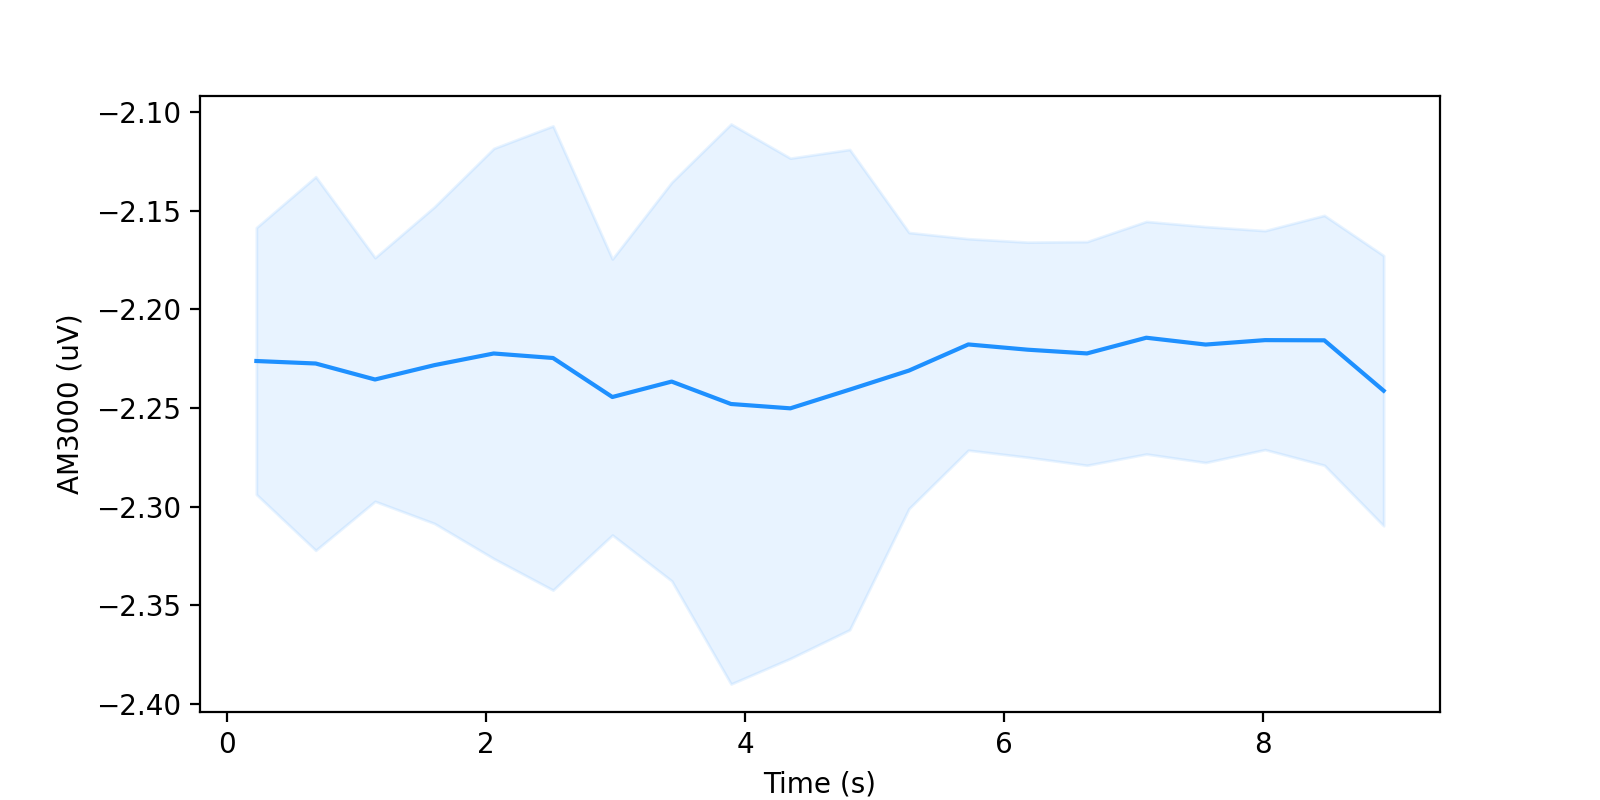

Text(0.5, 0, 'Time (s)')

In [21]:
# so those were our binned average voltages (will be your average firing rates) 
# let's average across trials and show the variance.  here i'll use SD, though SEM is more standard

fig6,ax6 = pl.subplots(figsize = (8,4))

avgavg = np.average(avg_voltages_bytrial,0)
stdev = np.std(avg_voltages_bytrial,0)

ax6.plot(times_of_chunks, avgavg, color="dodgerblue")

ax6.fill_between(times_of_chunks, avgavg+stdev, avgavg-stdev, color="dodgerblue", alpha=0.1)

ax6.set_ylabel(h1_label)
ax6.set_xlabel('Time (s)')


<span style="color:dodgerblue">So that's nice -- or, it will be, when your y axis is a firing rate -- but even then, it's not quite a tuning curve just yet.  Because a tuning curve isn't about the firing rate at time *X*, it's about the firing rate as a function of stimulus parameters.  Since I am motivated to get this tutorial out before the semester is over, I'm going to show you a bit of a shortcut way to portray that. </span>

<span style="color:dodgerblue">The author of the stimulus strips also provided a text file with the parameters that change per pixel/degree of the strip.</span>

In [29]:
# load strip parameters file
reader = csv.reader(open('BarPatternParams.txt', newline='', 
                         encoding='mac_roman'), delimiter= '\t')
#                        ^^^^^^^
# you may need a different encoding than the one listed here.
# See: https://docs.python.org/3/library/codecs.html#standard-encodings

            
rows = [] #this will be a list of each of the rows in the file

for row in reader:
    rows.append(row)
    
print(*rows[0:6],"...", *rows[-3:], sep="\n")

['Angle  Strip1  Strip2  Strip3  Strip4  Strip5']
['(DEG)  Contr.  Contr.  Phase   Dummy   Height']
[' ']
['0.00', '1.000', '0.000', '0.000', '0.000', '0.000']
['0.29', '1.000', '0.000', '0.000', '0.000', '0.000']
['0.59', '1.000', '0.000', '0.000', '0.000', '0.000']
...
['359.12', '1.000', '0.998', '214.517', '0.000', '0.991']
['359.41', '1.000', '0.999', '214.554', '0.000', '0.995']
['359.71', '1.000', '1.000', '214.591', '0.000', '1.000']


<span style="color:dodgerblue">In the columns of this tsv text file, we have degree coordinates, and the variable of interest on each strip (see "Overview of H1 data.pdf" for details) across the columns.</span>

In [30]:
# let's pull out the columns

strip_angle = []
s1_params = []
s2_params = []
s3_params = []
# strip 4 has no params 
s5_params = []

for row in rows[3:]:    # skip the header info
    strip_angle.append(float(row[0]))
    s1_params.append(float(row[1]))
    s2_params.append(float(row[2]))
    s3_params.append(float(row[3]))   
    s5_params.append(float(row[5]))

# print to spot check
print(strip_angle[0:3],strip_angle[-3:],)
print(s2_params[0:3],s2_params[-3:])

[0.0, 0.29, 0.59] [359.12, 359.41, 359.71]
[0.0, 0.0, 0.0] [0.998, 0.999, 1.0]


<IPython.core.display.Javascript object>


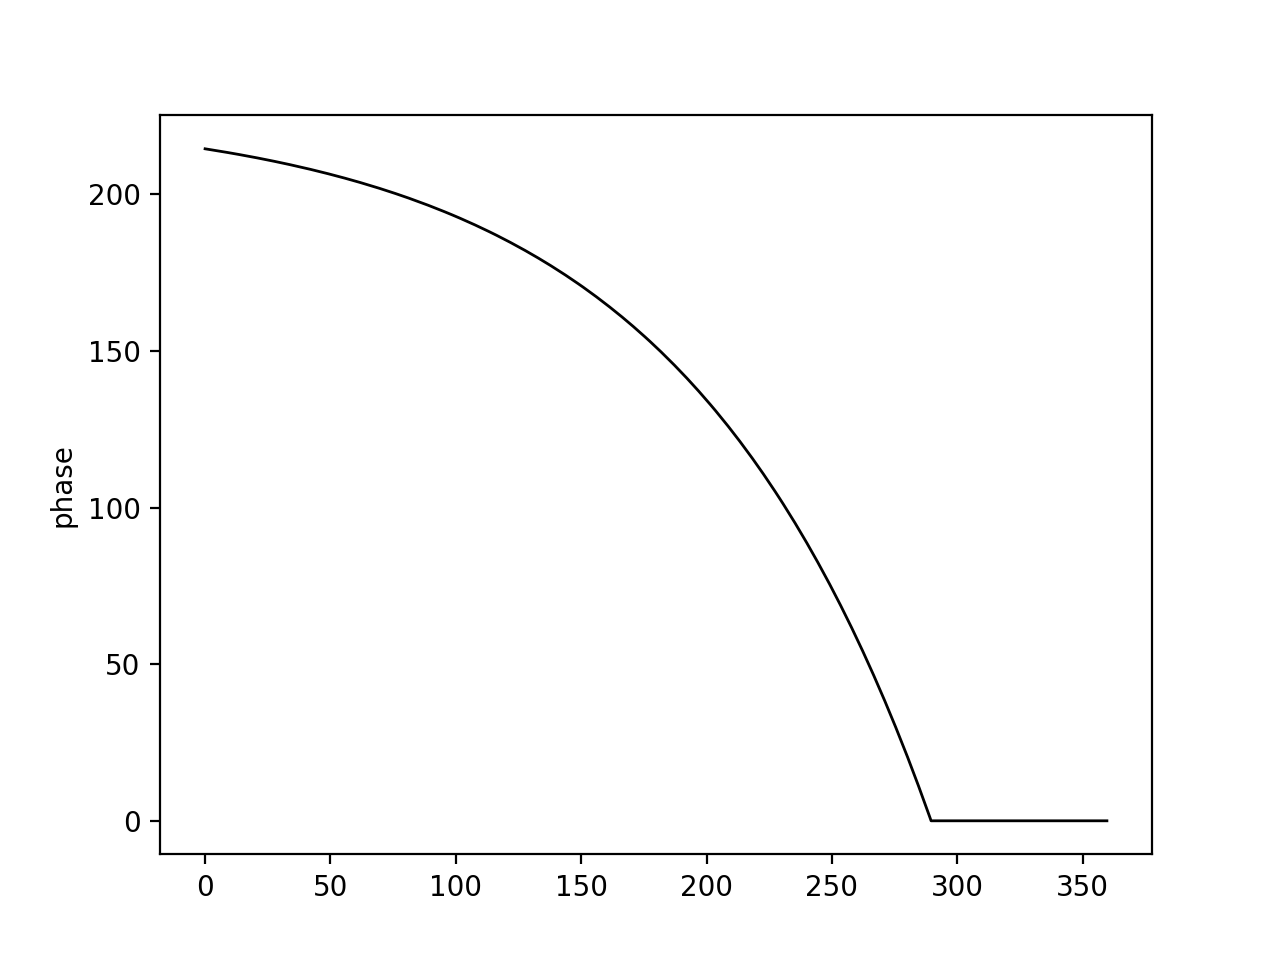

Text(0, 0.5, 'phase')

In [31]:
# the stimulus from file 014 was from bars of decreasing width, which is strip 3.

s3_params_rev = np.flip(s3_params)

fig7,ax7 = pl.subplots()
ax7.plot(strip_angle, s3_params_rev, color='black', lw=1)
ax7.set_ylabel('phase')

<span style="color:dodgerblue">My little trick/shortcut is to **replace the x axis** from fig6 with *an image of this plot*, so that it communicates that ~~avg voltage~~ firing rate as a function of the stimulus parameter.  It's still not a "proper" tuning curve, because we expect a tuning curve to have an x axis that is linearly mapped to this variable, but we'll leave that as an extension exercise if you're getting stir crazy during isolation.</span>
    
<span style="color:dodgerblue">There are several issues we need to solve to use this plot as our x axis:</span>
- <span style="color:dodgerblue">is the plot in fig7 properly aligned to the position signal peak we used at the edge of our chunks?</span>
- <span style="color:dodgerblue">we need to make it pretty</span>
- <span style="color:dodgerblue">fig7 indicates the variable state at a given position in the strip, but the fly doesn't see only that position -- it sees a window.  We could recalculate that curve using a sliding window, but to keep it simple we'll draw a box around what the fly can actually see in the stimulus window. </span>
- <span style="color:dodgerblue">you will also have to consider when you use a different file whether you need to flip the plot (as I've done above since this is decreasing rather than increasing bar width) or perform any other transforms.
    
<span style="color:dodgerblue">An alternative to using these approaches would be to similarly use the stimulus strip image itself under the x axis.  Look up [imshow](https://www.pyimagesearch.com/2014/11/03/display-matplotlib-rgb-image/), and be careful to line things up neatly.</span>



<IPython.core.display.Javascript object>


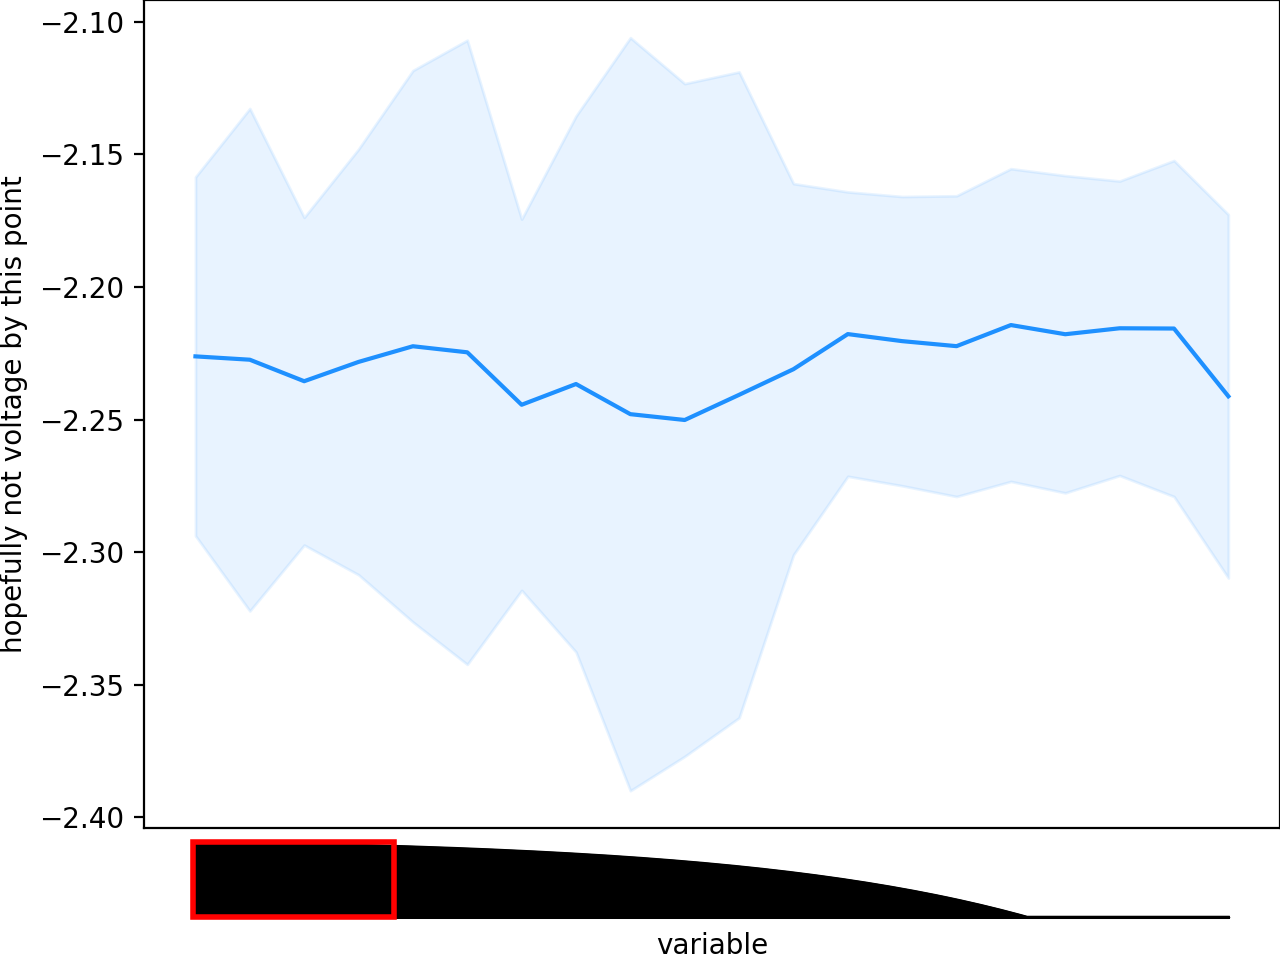

In [25]:
# we need to make it pretty

# 2 subplots; the top one is just fig 4 again

fig8,ax8 = pl.subplots(2,1,gridspec_kw={'height_ratios': [10, 1]})
ax8[0].plot(times_of_chunks, avgavg, color="dodgerblue")
ax8[0].fill_between(times_of_chunks, avgavg+stdev, avgavg-stdev, color="dodgerblue", alpha=0.1)
ax8[0].set_ylabel('hopefully not voltage by this point')

# get rid of x axis

ax8[0].xaxis.set_visible(False)

# make the plot of the strip variable
ax8[1].plot(strip_angle, s3_params_rev, color='black', lw=1)
ax8[1].fill_between(strip_angle,s3_params_rev,0,color="black")
ax8[1].set_xticks([])
ax8[1].set_yticks([])
ax8[1].set_xlabel('variable')

pl.box(False)  #remove border

fig8.tight_layout(pad=0)


In [26]:
# the width is 5 cm, which I read as # 566 pixels in IMG_6735.JPG
# draw a box around what the fly can actually see in the stimulus window at time 0.

rectangle = pl.Rectangle((-1, -0.1), 70, max(s3_params), color="red", lw=2, fill=False, zorder=10)
ax8[1].add_patch(rectangle);

The two plots in fig 8 line up properly because we've used each one's intrinsic x scale plotted to the same x range.  You will lose that if you zoom in.

<div class="alert alert-block alert-danger"> The red box drawn above is not in the correct place.  Since this was my mistake we won't penalize anyone for carrying it through, but I've illustrated how to fix it below.</div>



In [246]:
## where we drew that red box is wrong -- at the very beginning of pos(t)=5,
## the red box should have its *right* edge at x=0, not its left edge

## the width of the display window is 5 cm.  
## 5 cm corresponds to 75° of view in the cylinder, which I can express as 75 in ax8[1] terms.

## what is the mapping of 360° to indices in terms of the strip pixels/that text file?

strip_angle = np.array(strip_angle)  # need array for math later

## sanity checks

print(len(strip_angle))
print(strip_angle[0], strip_angle[1226])

1227
0.0 359.71


## remake fig8 with cycling parameter plot

<IPython.core.display.Javascript object>


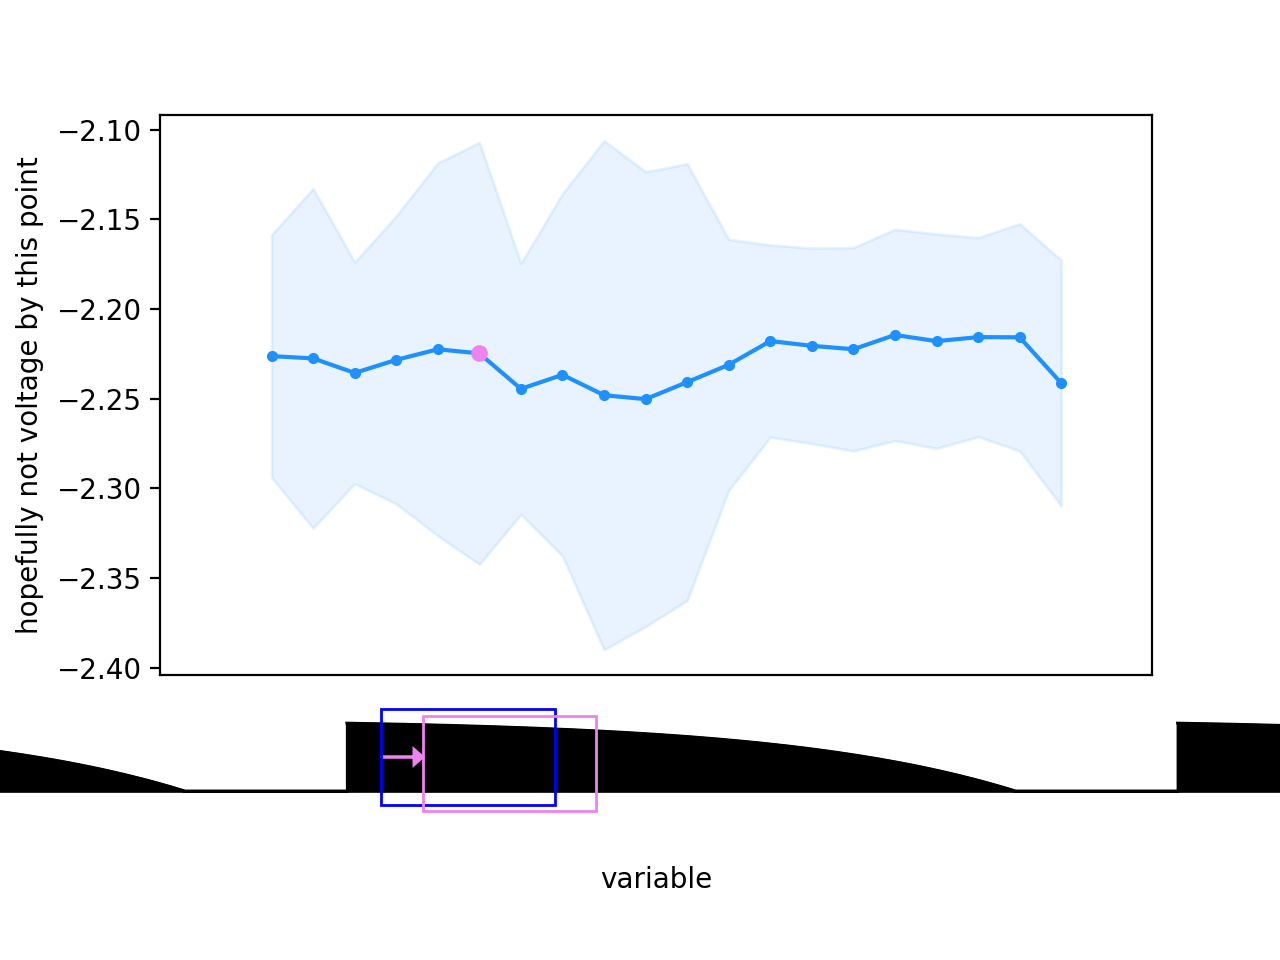

In [234]:
## let's take a pass at recursively plotting the axis image and drawing the red box correctly.

fig9,ax9 = pl.subplots(2, 1, sharex=False, gridspec_kw={'height_ratios': [10, 2]})

# turn off sharex so we can slide the bottom plot.

# map position in degrees into same x-space (here, the time-space for 1 trial)

trial_mapped_angle = np.interp(strip_angle,[0,360],[0,max(times_trials)])


ax9[0].plot(times_of_chunks, avgavg, color="dodgerblue", marker = ".")
ax9[0].fill_between(times_of_chunks, avgavg+stdev, avgavg-stdev, color="dodgerblue", alpha=0.1)
ax9[0].set_ylabel('hopefully not voltage by this point')
ax9[0].set_xlim(-1,max(times_of_chunks)+1)
ax9[1].set_xlim(-1,max(times_of_chunks)+1)
ax9[0].xaxis.set_visible(False)

# make the plot of the strip variable

time_step = max(trial_mapped_angle)

for x in ([time_step,0,time_step*-1]):   # plot three of them
    
    ax9[1].plot(trial_mapped_angle + x, s3_params_rev, color='black', lw=1, clip_on=False)
    ax9[1].fill_between(trial_mapped_angle + x,s3_params_rev,0,color="black", clip_on=False)


ax9[1].set_xticks([])
ax9[1].set_yticks([])
ax9[1].set_xlabel('variable')

pl.box(False)  #remove border



## how to put the box in the right place
(you can do this with one click under the following heading)

In [229]:
#let's position the rectangle correctly for time = 0

# need to map our degrees view (75) to the parameter space as well
# i.e. window size relative to the time coords for 1 trial

mapped_window = np.interp(75,[0,360],[0,max(times_trials)])

rectangle1 = pl.Rectangle((mapped_window * -1, 0-0.2*max(s3_params)), mapped_window, max(s3_params)*1.4, 
                         #( x=-75= left edge,    y=0 with padding,   width,         y=max + padding
                         
                         color="red", lw=1, fill=False, clip_on=False, zorder=10)

ax9[1].add_patch(rectangle1);

In [230]:
## now, where is that rectangle at the end time of the first chunk?
## it's the first window displaced by the length of a chunk, translated to this timespace

xshift = max(times_trials)/num_of_chunks # window shift in time per chunk
print(xshift)
rectangle2 = pl.Rectangle((mapped_window * -1 + xshift, 0-0.2*max(s3_params)), mapped_window, max(s3_params)*1.4, 
                         #                    ^^^^^^^^                           ^^ width doesn't change!   
                          
                         color="orange", lw=1, fill=False, clip_on=False, zorder=10)

ax9[1].add_patch(rectangle2);

0.4579750000000001


In [231]:
## let's be fancy

# pl.arrow(x, y, dx, dy, **kwargs)


x = mapped_window * -1    # left edge of red box
# x = 0                   # right edge of red box, if you prefer
y = max(s3_params)/2      # midpoint of the curve
dx = xshift
dy = 0

print(x, y, dx, dy,)

ax9[1].arrow(x, y, dx, dy, color="orange", head_width=50, head_length=0.1, length_includes_head=True, clip_on=False)

-1.9082291666666669 107.2955 0.4579750000000001 0


In [232]:
#call out FR of first chunk to match moving window

ax9[0].plot(times_of_chunks[0], avgavg[0], color="orange", marker = ".", markersize=10)

## plot the sliding display window for an arbitrary chunk

In [235]:
# sidebar 1 -  is it annoying that the stimulus representation is off the edge of the plot?
# we could do this for an arbitrary bin

# highlight a later/arbitrary chunk

chunk_to_plot = 5


## parameters
## sorry, mixing terminology... here `chunk` is a piece of a trial and `window` is the portion of the stimulus visible

mapped_window = np.interp(75,[0,360],[0,max(times_trials)]) # map 75° view window to timespace of 1 trial
                                                            # i.e., width of the box drawn.

xshift = max(times_trials)/num_of_chunks # window shift in time per chunk
    
    
x1 = (mapped_window * -1) + (chunk_to_plot * xshift) # left edge of first box
y1 = 0 # bottom of box without padding 
padding = 0.2*max(s3_params) # vertical padding of colored box

width = mapped_window    # width of box
height = max(s3_params)  # height of box, without padding




## creating plot objects

rectangle1 = pl.Rectangle((x1, y1-padding), width, height+(2*padding),
                          color="blue", lw=1, fill=False, clip_on=False, zorder=10)

rectangle2 = pl.Rectangle((x1 + xshift, y1-1.5*padding), mapped_window, height+(2*padding), 
                          color="violet", lw=1, fill=False, clip_on=False, zorder=10)

## plot them

ax9[1].add_patch(rectangle1);
ax9[1].add_patch(rectangle2);
ax9[1].arrow(x1, height/2, xshift, 0, color="violet", head_width=50, head_length=0.1, length_includes_head=True, clip_on=False)
ax9[0].plot(times_of_chunks[chunk_to_plot], avgavg[chunk_to_plot], color="violet", marker = ".", markersize=10)


## calculating the strip parameters in a sliding average per chunk

In [219]:
## so we did all that work to elegantly display what the moving stimulus captures,
## but actually all that work brings us really close to just going ahead and making the tuning curve `proper`
## i.e., we can use that sliding window we drew as the basis to calculate average parameter value

## this time we map the visible window back to strip parameter space instead of the time basis of 1 trial

mapped_window = int(np.interp(75,[0,360],[0,len(strip_angle)])) # map 75° view window to strip parameter index

#sanity check
print("75 degree window view should go from 0 to strip param index:", mapped_window)
print(" and the degree reported at that index is:", strip_angle[mapped_window])

75 degree window view should go from 0 to strip param index: 255
 and the degree reported at that index is: 74.82


In [220]:
xshift = int(len(strip_angle)/num_of_chunks) # window shift in strip parameter index

#sanity check
print(f"Each chunk shifts by ~{(xshift)} indices.")
print(f"This is sensible because {num_of_chunks} chunks * {xshift} = {num_of_chunks*xshift}")
print(f"and the total length of strip_angle is {len(strip_angle)}")

print(f"\n\nTo compute the average stimulus parameter per chunk," )
print(f"we will take a moving average of width {mapped_window} indices")
print(f"in a range of {mapped_window+xshift} indices")

Each chunk shifts by ~61 indices.
This is sensible because 20 chunks * 61 = 1220
and the total length of strip_angle is 1227


To compute the average stimulus parameter per chunk,
we will take a moving average of width 255 indices
in a range of 316 indices


In [221]:
chunk_id = 0

## for a given chunk, the coordinate of the left edge is chunk_id * xshift - mapped_window

x1 =  (chunk_id * xshift) - mapped_window # left edge of first box

## the coordinate of the right edge is chunk*id+1 * xshift

x2 =  (chunk_id+1) * xshift

print(x1,x2, x2-x1)

-255 61 316


In [222]:
## want to know something convenient?  we can use np.take() to grab a slice in a wrap-around fashion, instead
## of having to hand code around the edges of our strip.

## I'm doing that here with the reported angle (column 0 from the parameters text file) just because it's easier 
## to understand it having worked correctly.

wrapped_angle_window = np.take(strip_angle, range(x1,x2), mode='wrap')

print(wrapped_angle_window)



[285.18 285.48 285.77 ...  17.02  17.31  17.6 ]


In [223]:
## but now let's go ahead and calculate the moving average using the strip parameters.

wrapped_strip_param = np.take(s3_params_rev, range(x1,x2), mode='wrap')

## the simplest way to do this is to to a 1-d convolution, with each value in our kernel being evenly weighted.

avg_param = np.convolve(wrapped_strip_param, np.ones(mapped_window)/mapped_window, mode="valid").mean(axis=0)

print(avg_param)

25.60272068311195


<IPython.core.display.Javascript object>


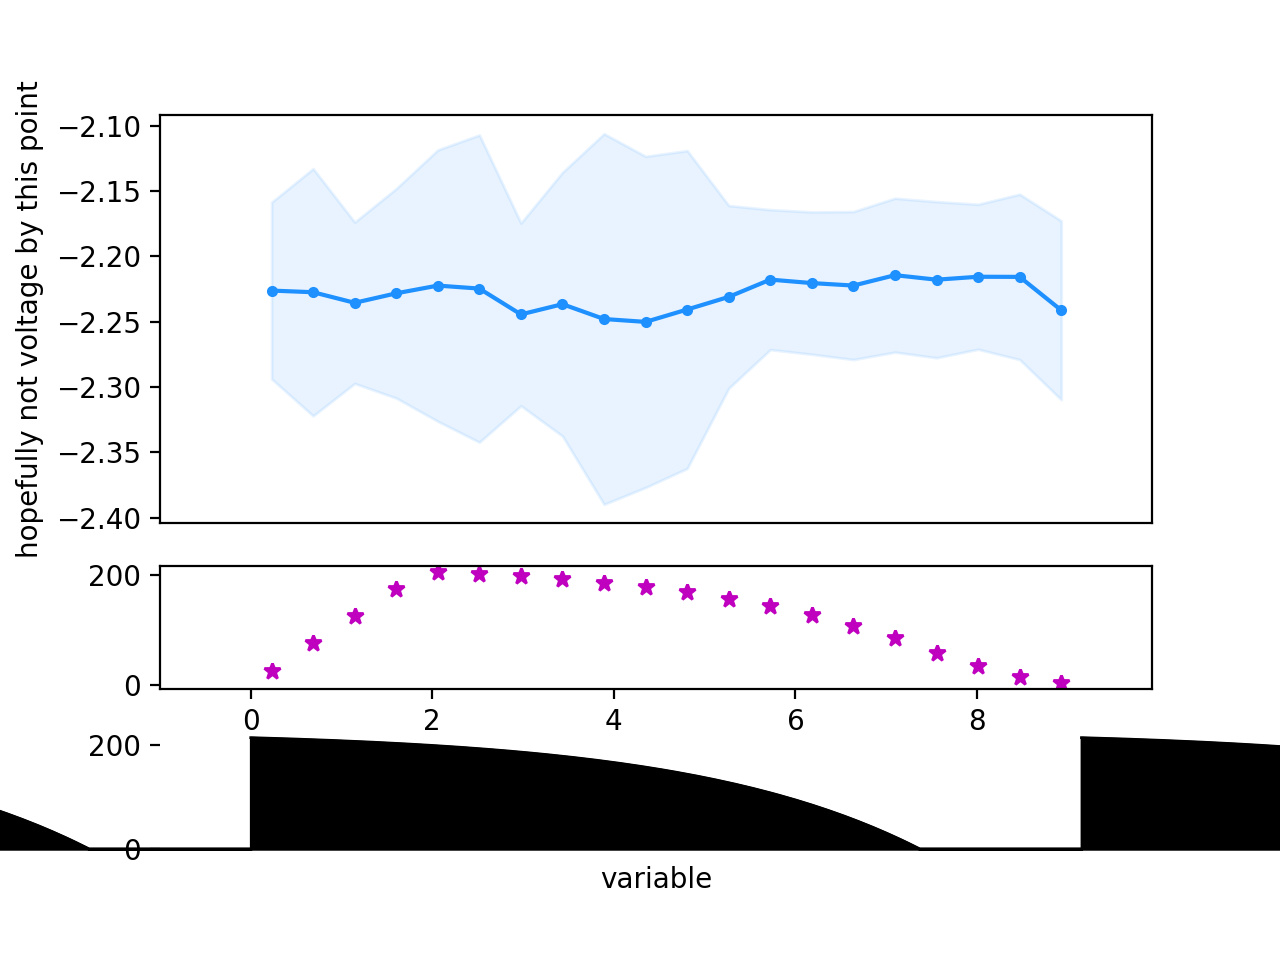

In [236]:
## so let's do this systematically and plot it with respect to the stim strip


## part 1: calculate avg strip param per chunk

mapped_window = int(np.interp(75,[0,360],[0,len(strip_angle)])) # map 75° view window to strip parameter index
xshift = int(len(strip_angle)/num_of_chunks) # window shift in strip parameter index

avg_params = []

for chunk_id in range(num_of_chunks):
    x1 =  (chunk_id * xshift) - mapped_window # left edge of first box
    x2 =  (chunk_id+1) * xshift
    wrapped_strip_param = np.take(s3_params_rev, range(x1,x2), mode='wrap')
    avg_param = np.convolve(wrapped_strip_param, np.ones(mapped_window)/mapped_window, mode="valid").mean(axis=0)
    avg_params.append(avg_param)
    

## part 2: duplicate figure 9 and add the plot of average strip parameter per chunk

fig10,ax10 = pl.subplots(3, 1, sharex=False, gridspec_kw={'height_ratios': [10, 3, 3]})

ax10[0].plot(times_of_chunks, avgavg, color="dodgerblue", marker = ".")
ax10[0].fill_between(times_of_chunks, avgavg+stdev, avgavg-stdev, color="dodgerblue", alpha=0.1)
ax10[0].set_ylabel('hopefully not voltage by this point')
ax10[0].set_xlim(-1,max(times_of_chunks)+1)
ax10[0].xaxis.set_visible(False)


## subplot 2: average strip param per chunk

ax10[1].plot(times_of_chunks,avg_params,'m*')
ax10[1].set_xlim(-1,max(times_of_chunks)+1)


## subplot 3: graph of strip params

time_step = max(trial_mapped_angle)

for x in ([time_step,0,time_step*-1]):
    ax10[2].plot(trial_mapped_angle + x, s3_params_rev, color='black', lw=1, clip_on=False)
    ax10[2].fill_between(trial_mapped_angle + x,s3_params_rev,0,color="black", clip_on=False)
ax10[2].set_xticks([])
# ax10[2].set_yticks([])
ax10[2].set_xlabel('variable')
ax10[2].set_xlim(-1,max(times_of_chunks)+1)
pl.box(False)  #remove border